<a href="https://colab.research.google.com/github/trey3p/emotion-music/blob/main/cnn_version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting GDrive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extracting Features

In [2]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

import numpy as np
import pickle
import joblib
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf

In [3]:


def padding(array, xx, yy):
  #Takes numpy array, desired height, and width and pads the array.

  h = array.shape[0]
  w = array.shape[1]

  a = max((xx - h) // 2,0)
  aa = max(0,xx - a - h)

  b = max(0,(yy - w) // 2)
  bb = max(yy - b - w,0)

  return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

def extract_features(y):
  max_size = 1500 #Max audio file width

  #Getting short-time Fourier transform and padding
  stft = padding(np.abs(librosa.stft(y, n_fft = 225, hop_length = 512)), 128, max_size)

  #Getting MFCCs and padding
  mfccs = padding(librosa.feature.mfcc(y, n_fft = 225, hop_length = 512, 
                                       n_mfcc = 225, S = np.abs(stft)**2), 128, max_size)
  
  #Getting the spectral centroid

  spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
  
  #Getting chromagram
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  
  #Getting spectral bandwith
  spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)


  #Now padding the spectral pandwith and 
  image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
  image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) 


  #Repeat padding for Spectral Bandwith, Spectral Centroid, Chromagram until they are the same
  # size as MFCC and STFT  
  for i in range(0,9):
    image = np.append(image,padding(normalize(spec_bw),1, max_size), axis=0)
    image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
    image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)
    
  image=np.dstack((image,np.abs(stft)))

  image=np.dstack((image,mfccs))

  return image



Creating Dataset with Features

In [4]:
df_music = pd.read_csv("/content/drive/MyDrive/Colab '22 - Plante/music_labels.csv")
df_music.head()

,alt,sponsor,race,affiliation,tone,MUSIC0,MUSIC1,MUSIC2,MUSIC3,MUSIC90,url
0,GOV_AL_WILSON_BUSINESS_MAN_AND_HUMBLE_SERVANT,"WILSON, ALBERT",GOVERNOR,DEMOCRAT,POSITIVE,1,0,0,0,0,https://wesmedia.wesleyan.edu/2020Ads/GOV_AL_W...
1,GOV_DE_CTI_CRONIES,CITIZENS FOR TRANSPARENCY AND INCLUSION,GOVERNOR,DEMOCRAT,NEGATIVE,0,0,0,1,0,https://wesmedia.wesleyan.edu/2020Ads/GOV_DE_C...
2,GOV_DE_CTI_UP_TO_US_60,CITIZENS FOR TRANSPARENCY AND INCLUSION,GOVERNOR,DEMOCRAT,NEGATIVE,0,0,0,1,0,https://wesmedia.wesleyan.edu/2020Ads/GOV_DE_C...
3,GOV_DE_CTI_WHITMER_PLOT,CITIZENS FOR TRANSPARENCY AND INCLUSION,GOVERNOR,DEMOCRAT,NEGATIVE,0,1,0,0,0,https://wesmedia.wesleyan.edu/2020Ads/GOV_DE_C...
4,GOV_DE_CTI_WHITMER_PLOT_2,CITIZENS FOR TRANSPARENCY AND INCLUSION,GOVERNOR,DEMOCRAT,NEGATIVE,0,1,0,0,0,https://wesmedia.wesleyan.edu/2020Ads/GOV_DE_C...


In [5]:
import random
from tqdm import tqdm
output_files = os.listdir("/content/drive/MyDrive/Colab '22 - Plante/output")
output_files = random.sample(output_files, 500)
features = []
ad_names = []
ominous = []
uplifting = []
sad = []
other = []

for i in tqdm(range(len(df_music))):
  if df_music['alt'][i] in output_files:
    y, sr = librosa.load("/content/drive/MyDrive/Colab '22 - Plante/output/" + df_music['alt'][i] + "/accompaniment.wav", 
                         duration = 30)
    features.append(extract_features(y))
    ad_names.append(df_music['alt'][i])
    ominous.append(df_music['MUSIC1'][i])
    uplifting.append(df_music['MUSIC2'][i])
    sad.append(df_music['MUSIC3'][i])
    other.append(df_music['MUSIC90'][i])

np.concatenate(features, axis = 0)
dataset = pd.DataFrame({'Ad Name' : ad_names , 'Ominous-Tense': ominous, 'Uplifting' : uplifting, 
                        'Sad-Sorrowful' : sad, 'Other' : other, 
                        'Features' : features})
dataset.to_pickle('dataset.pkl')



100%|██████████| 7357/7357 [17:01<00:00,  7.20it/s]


In [6]:
dataset.shape

(500, 6)

In [7]:
dataset.head()

,Ad Name,Ominous-Tense,Uplifting,Sad-Sorrowful,Other,Features
0,GOV_DE_CTI_CRONIES,0,0,1,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,GOV_IN_HOLCOMB_JANET_2,0,1,0,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,GOV_KY_ADKINS_IT_IS_TIME,0,1,0,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,GOV_KY_BESHEAR_IN_HIS_OWN_WORDS_15,1,0,0,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,GOV_KY_GOFORTH_WINNER,0,1,0,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


Performing Train-Test Split

In [8]:
X = np.array(features)
y = dataset[['Ominous-Tense', 'Uplifting', 'Sad-Sorrowful', 'Other']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state= 0, shuffle=True)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)
print(X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val))

(281, 128, 1500, 3) (125, 128, 1500, 3) (94, 128, 1500, 3) 281 125 94


In [10]:
X_train = np.array(X_train)

In [11]:
X_train = np.array((X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train)))
X_test = np.array((X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test)))
X_train = X_train/np.std(X_train)
X_test = X_test/np.std(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

Simple CNN

In [12]:
input_shape=(128,1500,3)
CNNmodel = models.Sequential()
CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(64, activation='relu'))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Dense(32, activation='relu'))
CNNmodel.add(layers.Dense(4, activation='softmax'))
CNNmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 1498, 32)     896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 749, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 749, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 747, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 373, 64)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 373, 64)       0

Compile the Model

In [13]:
CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

Fit the Model

In [14]:
history = CNNmodel.fit(X_train, y_train, epochs=20, validation_data= (X_val, y_val))

Epoch 1/20
9/9 [==============================] - 12s 310ms/step - loss: 2273.8174 - accuracy: 0.3381 - val_loss: 1.4313 - val_accuracy: 0.5638
Epoch 2/20
9/9 [==============================] - 1s 127ms/step - loss: 2.5218 - accuracy: 0.4235 - val_loss: 1.4543 - val_accuracy: 0.5106
Epoch 3/20
9/9 [==============================] - 1s 128ms/step - loss: 1.3825 - accuracy: 0.4733 - val_loss: 1.4345 - val_accuracy: 0.5745
Epoch 4/20
9/9 [==============================] - 1s 126ms/step - loss: 1.2950 - accuracy: 0.4911 - val_loss: 1.4289 - val_accuracy: 0.5745
Epoch 5/20
9/9 [==============================] - 1s 126ms/step - loss: 1.2708 - accuracy: 0.4057 - val_loss: 1.4167 - val_accuracy: 0.5745
Epoch 6/20
9/9 [==============================] - 1s 124ms/step - loss: 1.2186 - accuracy: 0.4520 - val_loss: 1.4128 - val_accuracy: 0.5745
Epoch 7/20
9/9 [==============================] - 1s 127ms/step - loss: 1.2240 - accuracy: 0.3915 - val_loss: 1.4063 - val_accuracy: 0.5745
Epoch 8/20
9/9 [

Evaluate the Model

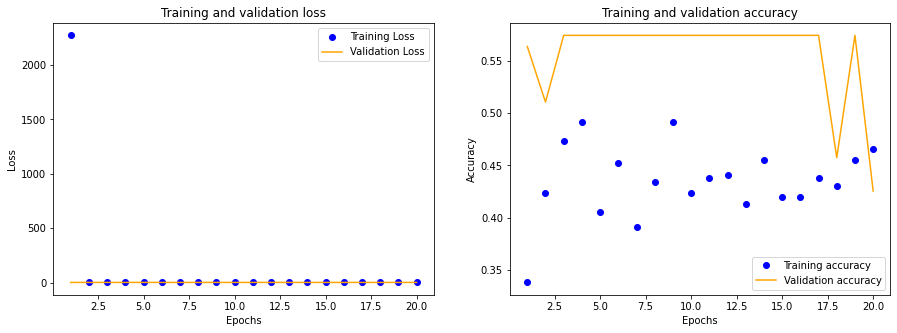

In [15]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,21)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()
